In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

故障检测


In [2]:
df = pd.read_csv('data.csv')
df['FINT_OCCUPY'] = df['FINT_OCCUPY']*0.01
df.head(5)
df.describe()
df.isnull().sum()
df.index
df_temp11 = df.groupby(['FSTR_LOOPGROUPID','FDT_TIME'])['FINT_VOLUME'].agg(['sum','count'])
df_temp11 = df_temp11.reset_index()
df = pd.merge(df,df_temp11,how='outer')
df


,,FSTR_LOOPGROUPID,FDT_TIME,FINT_VOLUME,FINT_SPEED,FINT_OCCUPY,sum,count
0,1,NHNX39(2),2010-04-18 00:00:20,4,71,0.09,4,1
1,2,NHNX39(1),2010-04-18 00:00:20,6,69,0.12,6,1
2,3,NHWN-NI-2(2),2010-04-18 00:00:20,0,0,0.00,0,1
3,4,NHWN-NI-2(1),2010-04-18 00:00:20,0,0,1.00,0,1
4,5,NHWN-NI-1(2),2010-04-18 00:00:20,0,0,0.00,0,1
...,...,...,...,...,...,...,...,...
435523,25904,NHNX39(1),2010-04-24 23:59:00,4,70,0.06,4,1
435524,25905,NHWN-NI-2(2),2010-04-24 23:59:00,2,35,0.03,2,1
435525,25906,NHWN-NI-2(1),2010-04-24 23:59:00,6,31,0.09,6,1
435526,25907,NHWN-NI-1(2),2010-04-24 23:59:00,3,35,0.04,3,1


In [3]:

df['SPEED_AVG']=(df['FINT_VOLUME']*df['FINT_SPEED']*df['count'])/df['sum']
# df['SPEED_AVG']=df['FINT_SPEED']
df = df.fillna(0)
df = df.groupby(['FSTR_LOOPGROUPID',
            'FDT_TIME'])['FINT_VOLUME',
                        'FINT_OCCUPY','SPEED_AVG'].agg(np.nanmean)
df = df.fillna(0)
df = df.loc['NHNX39(1)      ']
og_df = df.copy()

C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/645348148.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df = df.groupby(['FSTR_LOOPGROUPID',


In [4]:
df = df.reset_index()
df['FDT_TIME'] = pd.to_datetime(df['FDT_TIME'])
df
target_time = pd.date_range(start = '2010-04-18 00:00:00',
                            end = '2010-04-24 23:59:40',
                            freq='20S')
target_time = pd.DataFrame({'FDT_TIME':target_time})
target_time
df = pd.merge(target_time,df, on='FDT_TIME', how='outer')
df
df.isnull().sum()

FDT_TIME        0
FINT_VOLUME    57
FINT_OCCUPY    57
SPEED_AVG      57
dtype: int64

In [5]:
def get_df_list(data=df,bin_num=7):
    step=len(data)/bin_num
    return [df.loc[range(int(step*(i)),int(step*(i+1)))] for i in range(bin_num)]
df_hour = get_df_list(bin_num=168)
df_day = get_df_list(bin_num=7)


独立判断法

In [6]:
def individual_judge(data=df,
                volume_lim=[0,17],
                occupy_lim=[0,0.8],
                speed_lim=[0,120]):
        result = (volume_lim[0]<= data.FINT_VOLUME) \
            * (data.FINT_VOLUME <=volume_lim[1]) \
            * (occupy_lim[0]<= data.FINT_OCCUPY) \
            * (data.FINT_OCCUPY <=occupy_lim[1]) \
            * (speed_lim[0]<= data.SPEED_AVG) \
            * (data.SPEED_AVG <=speed_lim[1])        
        data['individual_judge'] =  result
        data['individual_judge'] = data.individual_judge.map({True:1, False:0})
        return df['individual_judge'].sum()/len(df)
individual_judge()


0.9928571428571429

联合判断法

交通流机理法，先获取流量和占有率关系模型参数

In [7]:
import statsmodels.api as sm

O = np.column_stack((np.array(og_df.FINT_OCCUPY)**2,np.array(og_df.FINT_OCCUPY)))
V = np.array(og_df.FINT_VOLUME)
O = sm.add_constant(O)

model = sm.OLS(V,O)
results = model.fit()
[a,b,r] = results.params
results.params

array([  1.71446483, -45.74816704,  34.64683592])

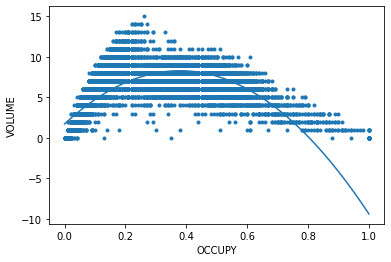

In [10]:
plt.scatter(df.FINT_OCCUPY,df.FINT_VOLUME,marker='.')
plt.xlabel('OCCUPY')
plt.ylabel('VOLUME')
eg_x = np.linspace(start=0,stop=1,num=len(df))
eg_y = a + b*eg_x**2 + r*eg_x
plt.plot(eg_x,eg_y)

In [11]:
k = df.FINT_VOLUME*3/df.SPEED_AVG

In [12]:
df.FINT_VOLUME.describe()

count    30183.000000
mean         4.768611
std          2.937073
min          0.000000
25%          2.000000
50%          5.000000
75%          7.000000
max         15.000000
Name: FINT_VOLUME, dtype: float64

In [11]:
# def joint_judge(data=df, rule1=[],rule2=[],rule3=[]):
#     result = (df.FINT_VOLUME<= a + b*df.FINT_OCCUPY**2 + r*df.FINT_OCCUPY +k*4.300128)*\
#         (df.FINT_VOLUME>= a + b*df.FINT_OCCUPY**2 + r*df.FINT_OCCUPY -k*4.300128)
#     return result
# df['joint_judge'] = joint_judge()
# df['joint_judge'] = df.joint_judge.map({True:1, False:0})

In [12]:
# np.logical_not(df['joint_judge']).sum()

In [13]:
# sns.scatterplot(data=df,x='FINT_OCCUPY',y='FINT_VOLUME',hue='joint_judge')

逻辑判别法

In [13]:
def joint_judge(data=df, rule1=[],rule2=[],rule3=[]):
    result = (np.logical_not((data.FINT_VOLUME == 0) * (data.FINT_OCCUPY != 0) * (data.SPEED_AVG != 0)))\
                *(np.logical_not((data.FINT_VOLUME != 0) * (data.FINT_OCCUPY == 0) * (data.SPEED_AVG != 0)))\
                *(np.logical_not((data.FINT_VOLUME != 0) * (data.FINT_OCCUPY != 0) * (data.SPEED_AVG == 0)))\
                *(data.FINT_VOLUME>=0)
    data['joint_judge'] = result
    data['joint_judge'] = data.joint_judge.map({True:1, False:0})
    return data['joint_judge'].sum()/len(data)
joint_judge()


0.9975859788359789

In [14]:
len(df)*(1-joint_judge())

72.99999999999862

In [15]:
# sns.scatterplot(data=df,x='FINT_OCCUPY',y='FINT_VOLUME',hue='joint_judge')

平均有效长度法

In [16]:
def aevl_judge(data=df):
    AEVL = data.SPEED_AVG*1000*data.FINT_OCCUPY/(data.FINT_VOLUME*3*60)
    result = (AEVL<=12)*(AEVL>=3)\
                *(data.FINT_VOLUME>=0)
    data['aevl_judge'] =  result
    data['aevl_judge'] = data.aevl_judge.map({True:1, False:0})
    return data['aevl_judge'].sum()/len(data)
aevl_judge()


0.886739417989418

In [17]:
len(df)-df.aevl_judge.sum()

3425

综合判断

In [18]:
def comprehensive_judge(data=df):
    joint_judge(data=data)
    individual_judge(data=data)
    aevl_judge(data=data)
    data['comprehensive_judge'] = data['aevl_judge']*data['joint_judge']*data['individual_judge']
    return data['comprehensive_judge'].sum()/len(data)
comprehensive_judge()

0.8849537037037037

In [19]:
len(df)-df.comprehensive_judge.sum()

3479

绘制时序图

In [20]:
effective_rate_hour = [comprehensive_judge(df_hour[i]) for i in range(7*24)]
effective_rate_day = [comprehensive_judge(df_day[i]) for i in range(7)]

Text(0, 1, 'Percentage')

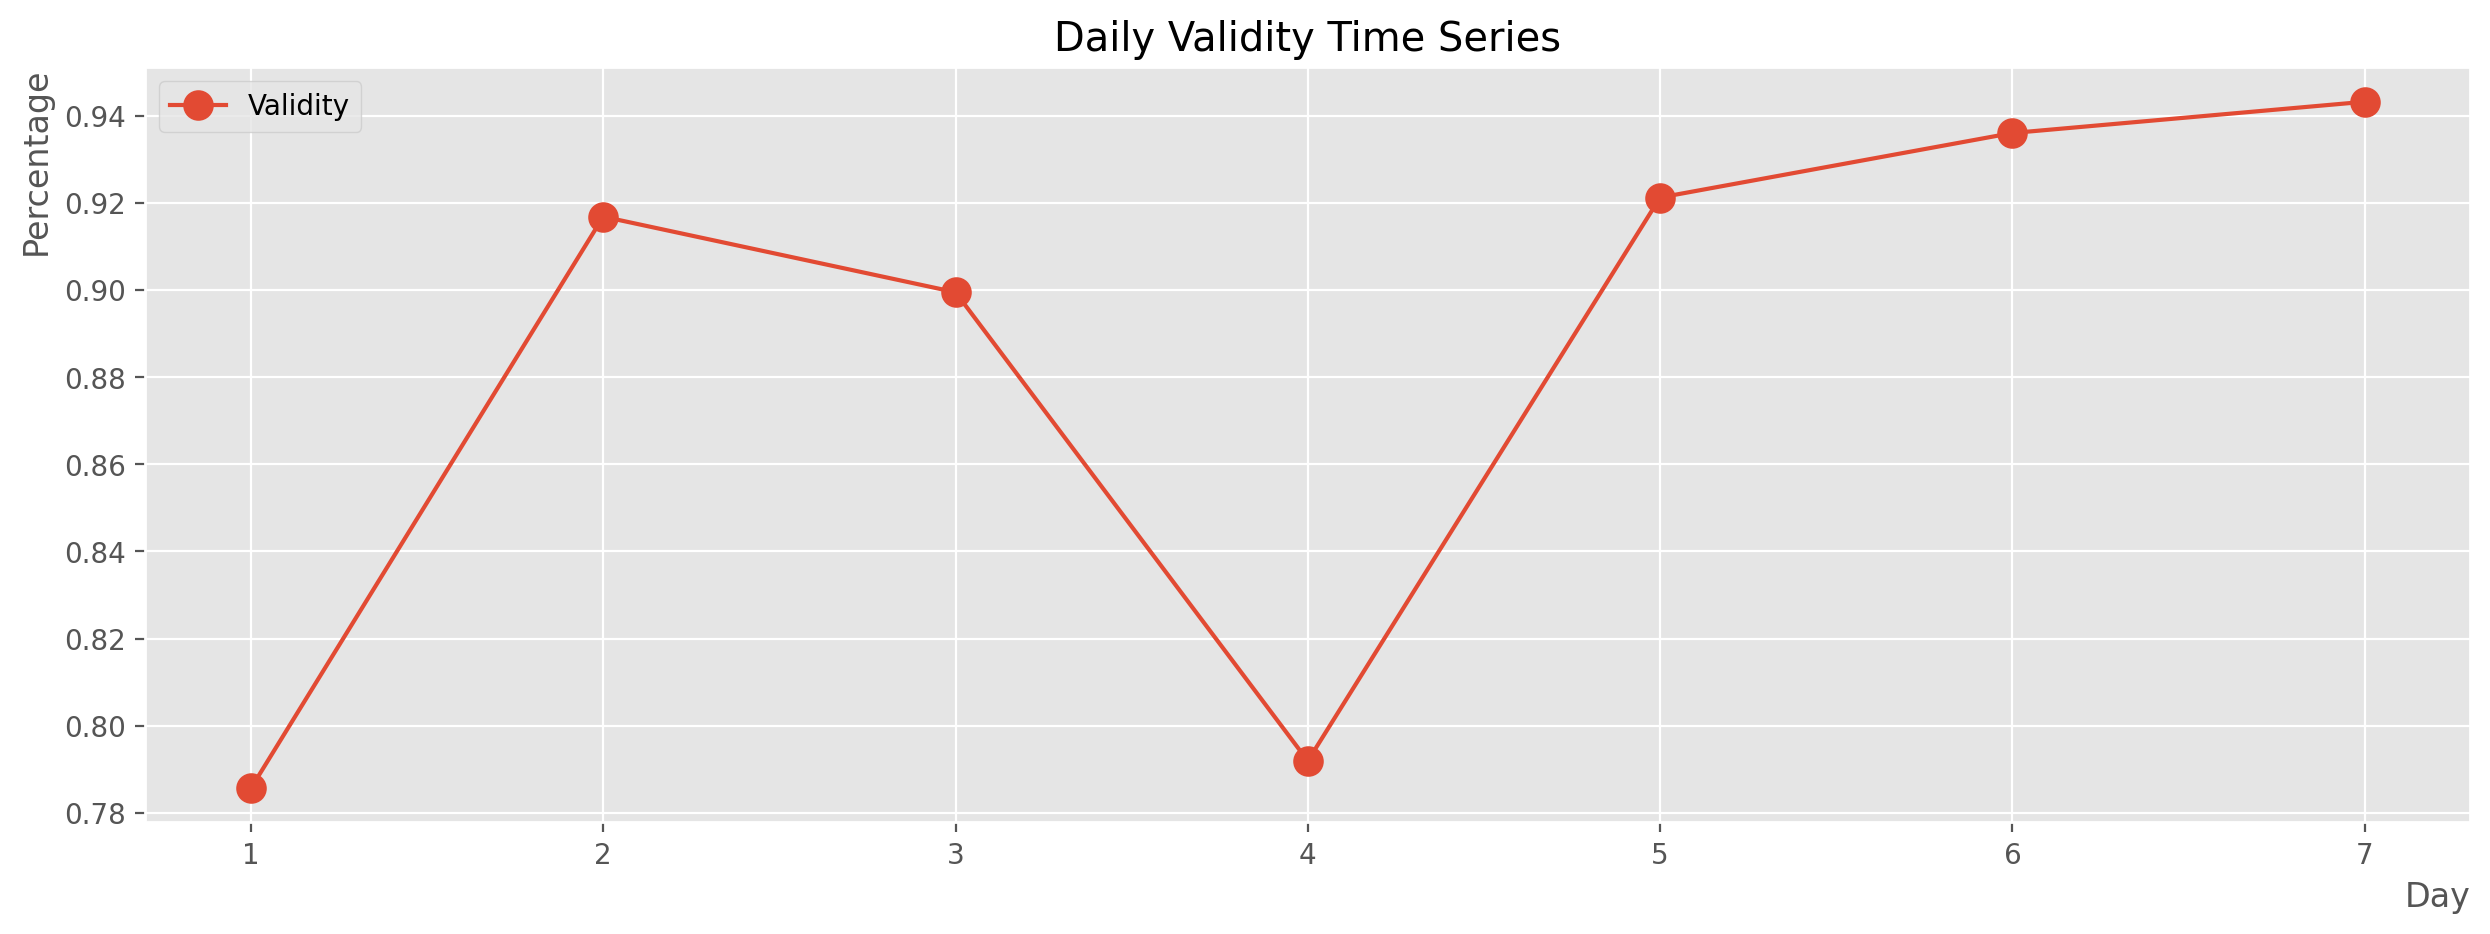

In [21]:
plt.figure(figsize=[15,5],dpi=200)
plt.style.use('ggplot')
plt.plot(range(1,8),effective_rate_day,marker='.',markersize=20,label='Validity')
plt.legend()
plt.title('Daily Validity Time Series')
plt.xlabel('Day',loc='right')
plt.ylabel('Percentage',loc='top')

In [22]:
np.array([list(range(0,24,4)) for i in range(7)]).flatten()

array([ 0,  4,  8, 12, 16, 20,  0,  4,  8, 12, 16, 20,  0,  4,  8, 12, 16,
       20,  0,  4,  8, 12, 16, 20,  0,  4,  8, 12, 16, 20,  0,  4,  8, 12,
       16, 20,  0,  4,  8, 12, 16, 20])

Text(0, 1, 'Percentage')

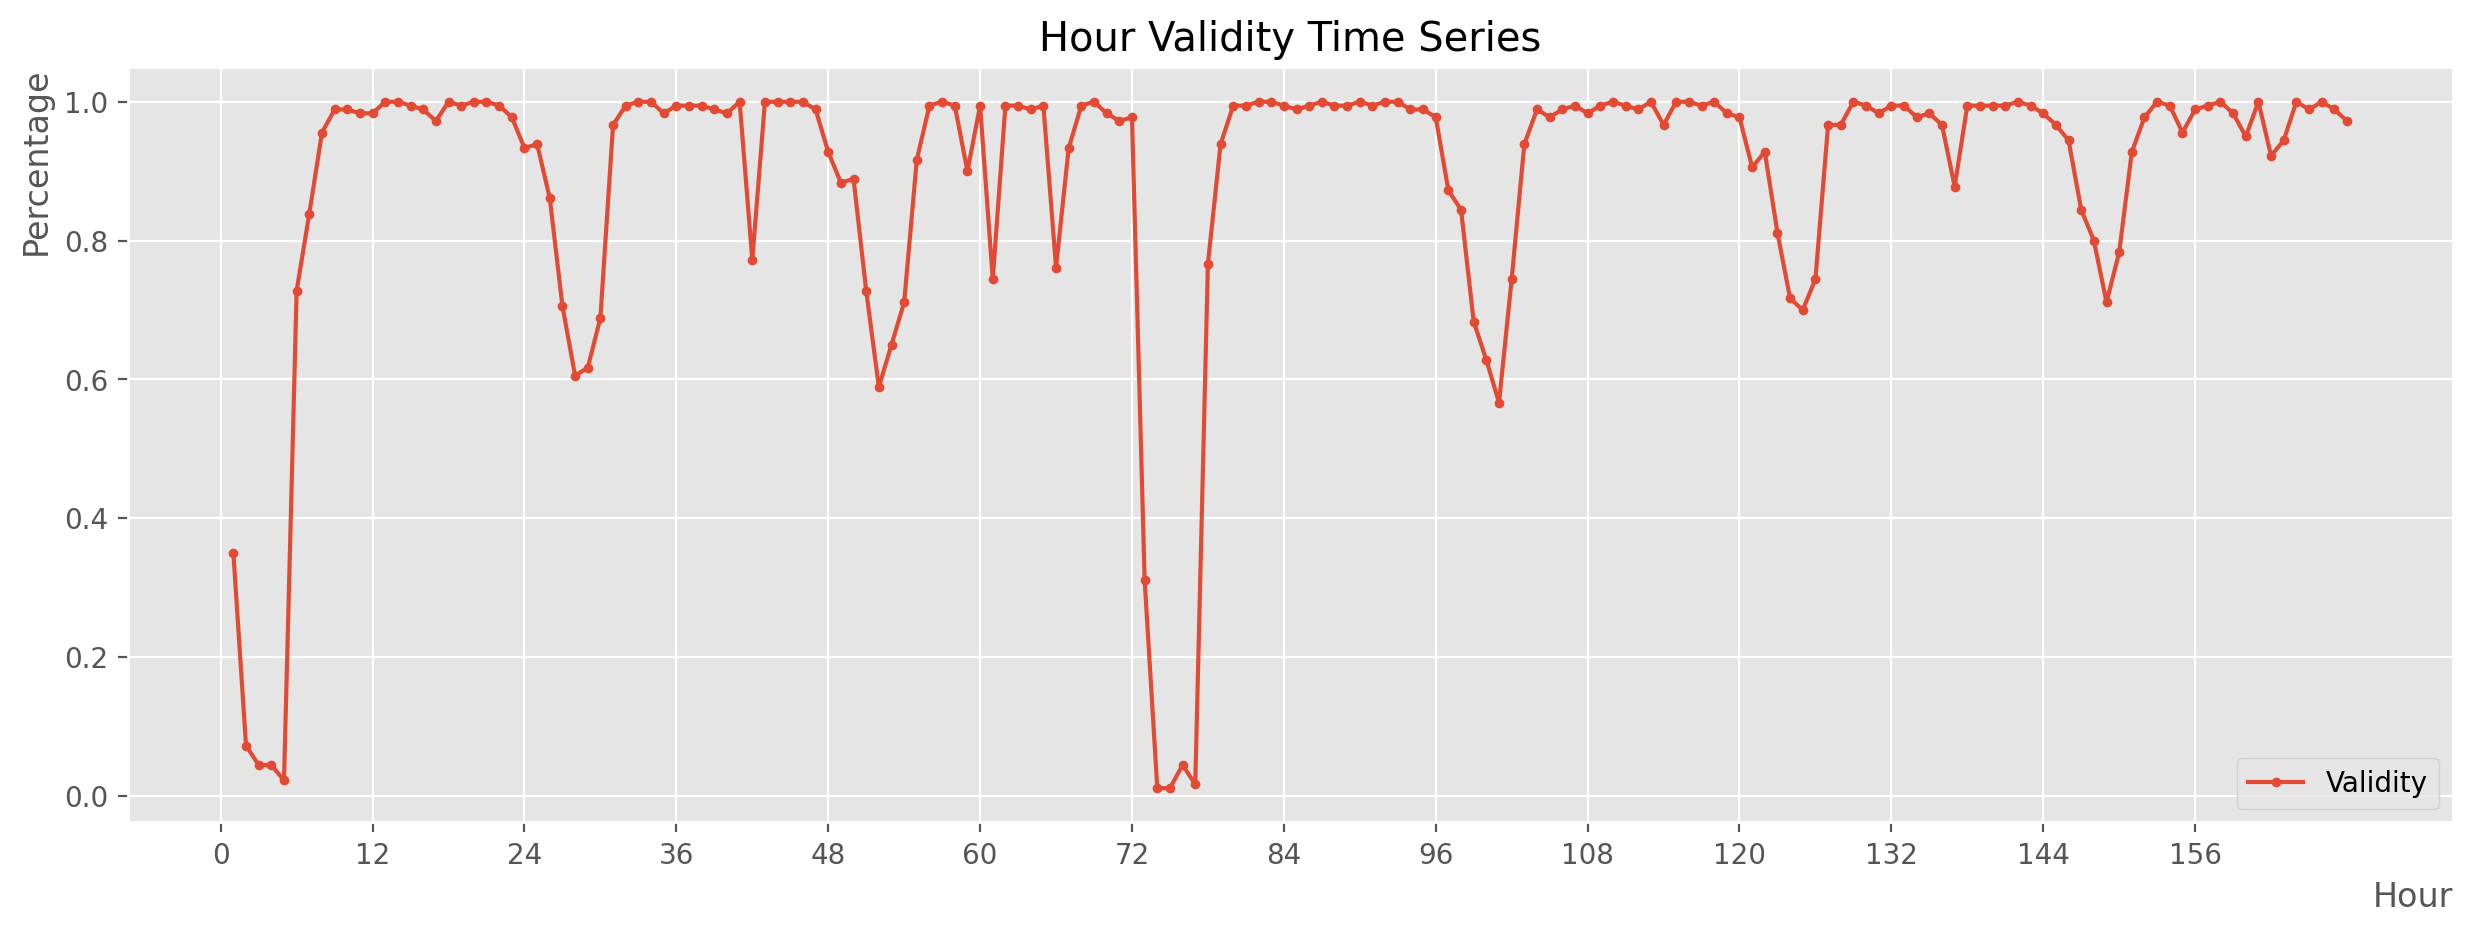

In [23]:
# plt.figure(figsize=[20,5],dpi=200)
plt.figure(figsize=[15,5],dpi=200)
plt.style.use('ggplot')
plt.plot(range(1,7*24+1),effective_rate_hour,marker='.',markersize=5,label='Validity')
plt.xticks(np.array(list(range(0,len(effective_rate_hour),12))))
plt.legend()
plt.title('Hour Validity Time Series')
plt.xlabel('Hour',loc='right')
plt.ylabel('Percentage',loc='top')

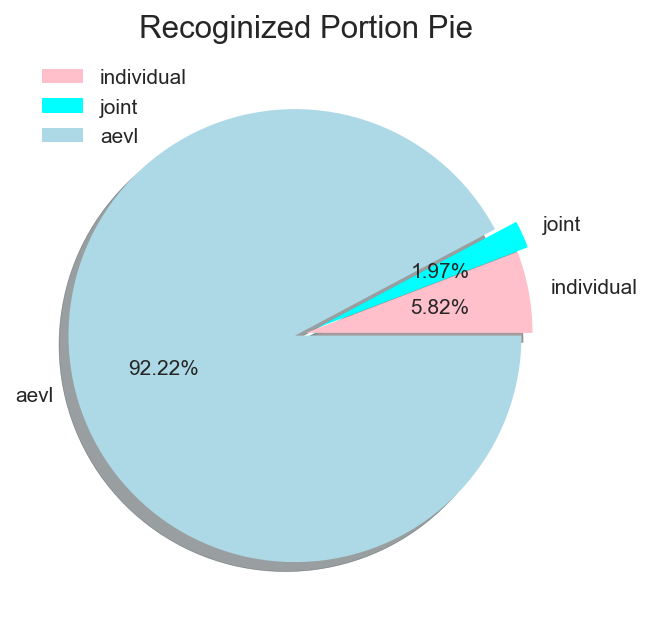

In [24]:
plt.style.use('seaborn')
num1 = 1-individual_judge()
num2 = 1-joint_judge()
num3 = 1-aevl_judge()
sum_num =num1+num2+num3
plt.figure(figsize=[20,5],dpi=150)
plt.pie(labels=['individual','joint','aevl'], 

        x=[num1/sum_num,
        num2/sum_num,
        num3/sum_num],
        explode=[0,0.05,0.05], 
        colors=['pink', 'cyan','lightblue'],
        shadow=True,
        autopct='%.2f%%')
plt.title('Recoginized Portion Pie', fontsize=15)
plt.legend(loc='upper left')


数据修复

In [25]:
df2 = pd.read_csv('data_for_imputation.csv')
drop_idx = np.random.choice(a=df2.index,size=100,replace=False)
backup = pd.DataFrame({'speed_391_24':np.zeros(100)})
backup.index=drop_idx
for i in drop_idx:
    backup['speed_391_24'].loc[i]=df2['speed_391_24'].loc[i]
    df2['speed_391_24'].loc[i]=np.nan
df2

,speed_391_24,speed_391_23,speed_391_22,speed_392_24,speed_401_24
0,64.0,78,83,73,72
1,77.0,82,81,78,65
2,80.0,81,80,78,73
3,68.0,80,81,74,67
4,72.0,77,78,74,50
...,...,...,...,...,...
3592,92.0,82,64,77,55
3593,87.0,77,78,109,71
3594,93.0,75,72,93,81
3595,64.0,69,82,69,81


In [26]:
df2.isnull().sum()

speed_391_24    100
speed_391_23      0
speed_391_22      0
speed_392_24      0
speed_401_24      0
dtype: int64

In [27]:
df2

,speed_391_24,speed_391_23,speed_391_22,speed_392_24,speed_401_24
0,64.0,78,83,73,72
1,77.0,82,81,78,65
2,80.0,81,80,78,73
3,68.0,80,81,74,67
4,72.0,77,78,74,50
...,...,...,...,...,...
3592,92.0,82,64,77,55
3593,87.0,77,78,109,71
3594,93.0,75,72,93,81
3595,64.0,69,82,69,81


In [28]:
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

def impute_plot(data=df2, imputer=KNNImputer(),param='n_neighbors'):
       og_data=data.copy()
       rmse_array=[]
       mape_array=[]
       inputed_df2 = data.copy()
       if param=='n_neighbors':
              for k in range(1,20):
              # imputer = KNNImputer(n_neighbors=k)
                     imputer.n_neighbors=k
                     inputed_df2['speed_391_24']=imputer.fit_transform(np.array(og_data))[:,0]
                     rmse_array.append(mean_squared_error(
                                                        y_true=np.array(backup).flatten(),
                                                        y_pred=inputed_df2['speed_391_24'].loc[backup.index],
                                                        squared=False
                                                        )
                                   )
                     mape_array.append(mean_absolute_percentage_error(
                                                        y_true=np.array(backup).flatten(),
                                                        y_pred=inputed_df2['speed_391_24'].loc[backup.index],
                                                                      )
                                   )
       if param=='n_nearest_features':
              for k in range(1,5):
                     imputer.n_nearest_features=k
                     inputed_df2['speed_391_24']=imputer.fit_transform(np.array(og_data))[:,0]
                     rmse_array.append(mean_squared_error(
                                                        y_true=np.array(backup).flatten(),
                                                        y_pred=inputed_df2['speed_391_24'].loc[backup.index],
                                                        squared=False
                                                        )
                                   )
                     mape_array.append(mean_absolute_percentage_error(
                                                        y_true=np.array(backup).flatten(),
                                                        y_pred=inputed_df2['speed_391_24'].loc[backup.index],
                                                                      )
                                   )
       fig,ax = plt.subplots(2,1,figsize=[5,7],dpi=200)
       plt.style.use('ggplot')
       ax1=ax[0]
       ax2=ax[1]
       ax1.plot(range(1,k+1),rmse_array,label='RSME')
       # ax1.setxlabel('k',loc='right')
       ax1.legend()
       ax2.plot(range(1,k+1),mape_array,label='MAPE')
       ax2.legend()
       
       if param=='n_neighbors':
              ax1.set_title('KNN Imputing')
              ax1.set_xticks(range(1,22,2))
              ax2.set_xticks(range(1,22,2))
              ax1.set_yticks(np.arange(6.8,10.2,0.2))
              plt.xlabel('k',loc='right')

       else:
              ax1.set_title('Multiple Imputing')
              ax1.set_yticks(range(7,18,1))
              ax2.set_yticks(np.arange(0.1,0.71,0.05))
              ax1.set_xticks(range(1,5))
              ax2.set_xticks(range(1,5))
              plt.xlabel('n_nearest_features',loc='right')
              


       # plt.xticks(range(1,k+1))
       print('rmse:',rmse_array)
       print('mape:',mape_array)




rmse: [9.301612763386787, 8.084862398334309, 7.928920341243049, 7.414681382230797, 7.1306661680378784, 6.802368868432689, 6.887877549931993, 6.747951077919875, 6.658374472593438, 6.734107216253688, 6.6675419535597475, 6.774149188069467, 6.835220310011268, 6.92934826278336, 6.926945775576547, 6.863658258356108, 6.852148401506128, 6.928428197214041, 6.953715203015849]
mape: [0.20730901248355643, 0.19158683865880868, 0.18453458346334553, 0.16829370638130814, 0.16611461538855532, 0.15829190742963564, 0.16129124323447974, 0.16082632695769847, 0.16184928477644028, 0.167475556965174, 0.16499831511981886, 0.16651574229410707, 0.16778883115022225, 0.17067890745733286, 0.16981463653292464, 0.1650875806583435, 0.16711591371556267, 0.17051771844489708, 0.1710060093135334]


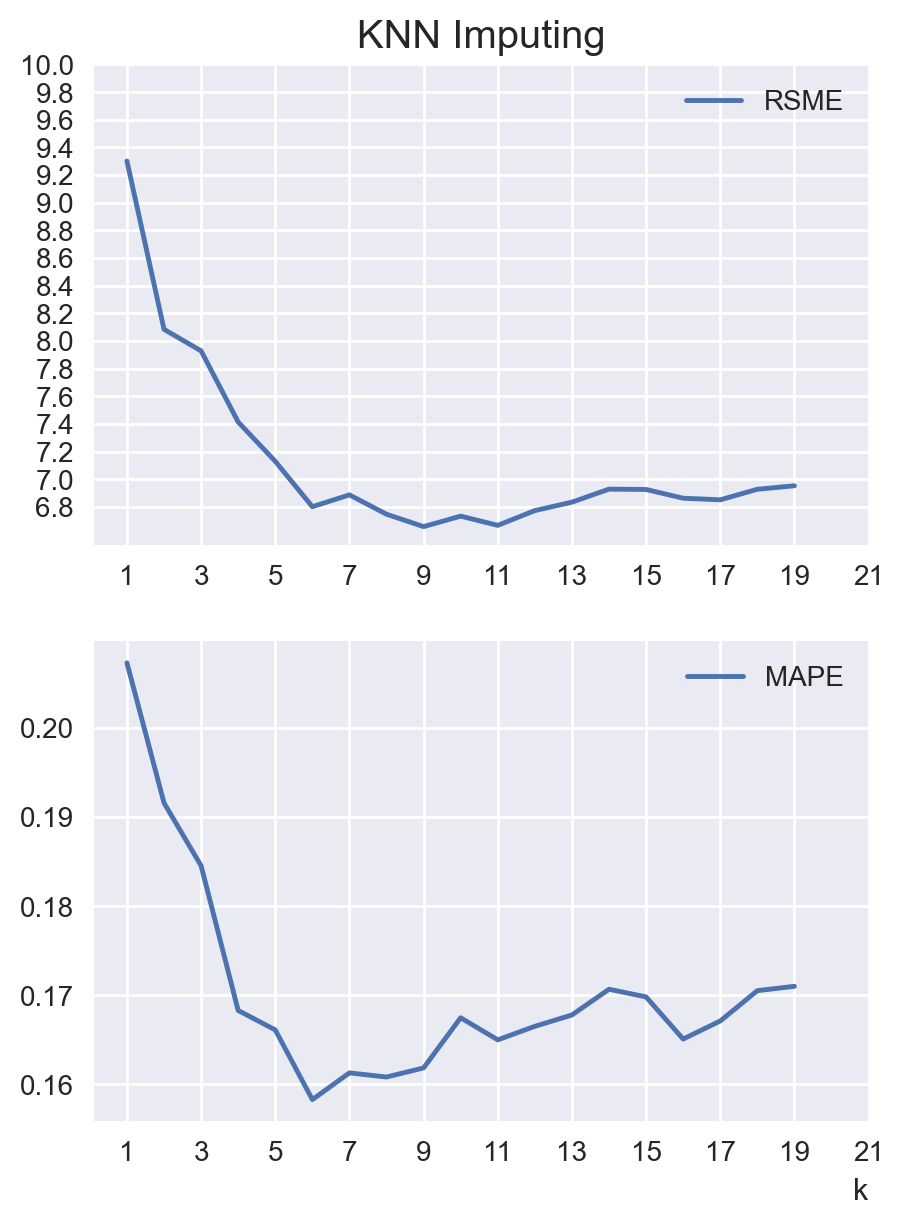

In [29]:
impute_plot(data=df2, imputer=KNNImputer())


D:\programs\envs\python38\lib\site-packages\sklearn\impute\_iterative.py:685: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn("[IterativeImputer] Early stopping criterion not"


rmse: [21.87582700457729, 19.93790284145875, 6.719832800864933, 6.695447055918084]
mape: [0.9065859799701986, 0.842579644958172, 0.164853887084526, 0.1670369825231297]


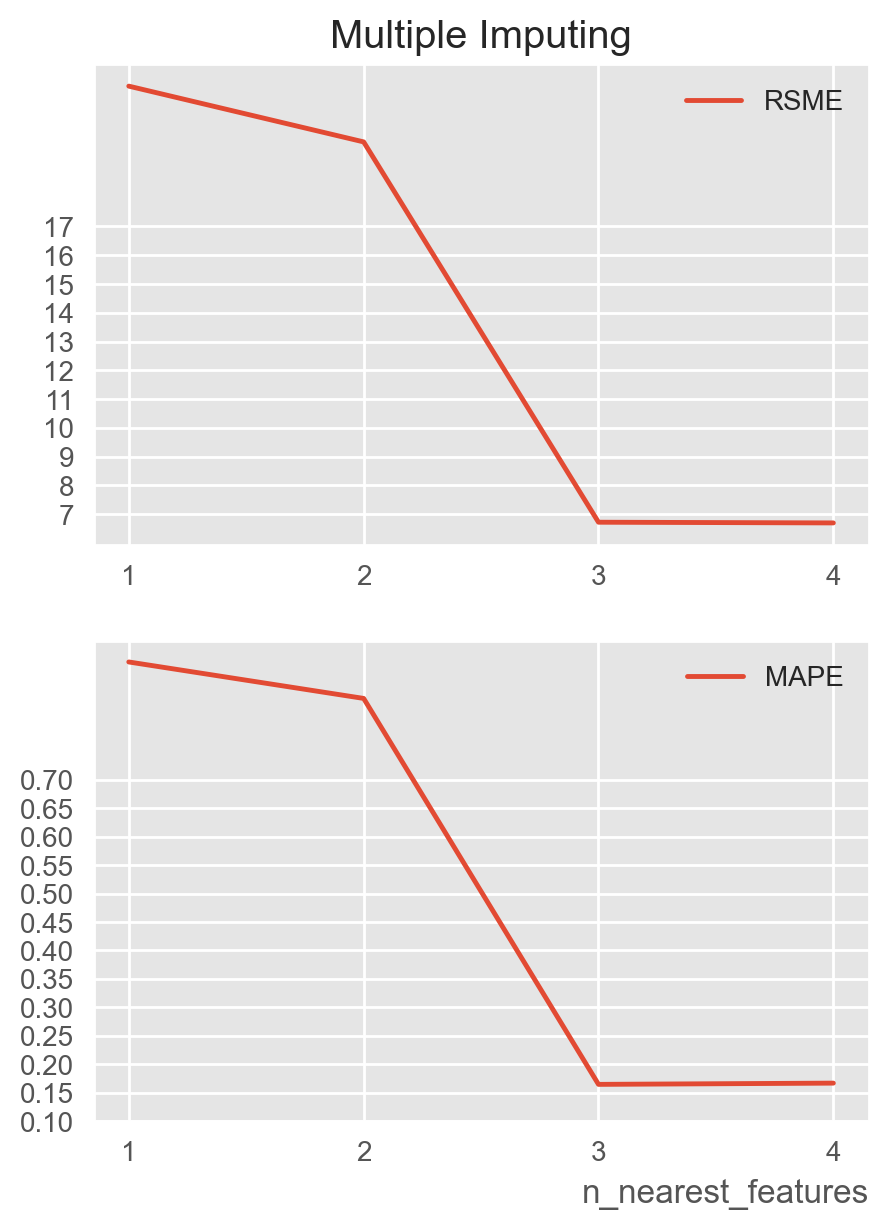

In [30]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
impute_plot(data=df2, imputer=IterativeImputer(),param='n_nearest_features')

数据平滑处理

In [31]:
og_df.index = pd.to_datetime(og_df.index)

In [32]:
smoothen_df = og_df.loc[('2010-04-24 16:00:00'<=og_df.index) * (og_df.index<'2010-04-24 18:00:00')]
smoothen_df.drop(['FINT_VOLUME','FINT_OCCUPY'],axis=1,inplace=True)
smoothen_df

D:\programs\envs\python38\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,SPEED_AVG
FDT_TIME,
2010-04-24 16:00:00,73.0
2010-04-24 16:00:20,76.0
2010-04-24 16:00:40,61.0
2010-04-24 16:01:00,66.0
2010-04-24 16:01:20,72.0
...,...
2010-04-24 17:58:20,18.0
2010-04-24 17:58:40,10.0
2010-04-24 17:59:00,18.0


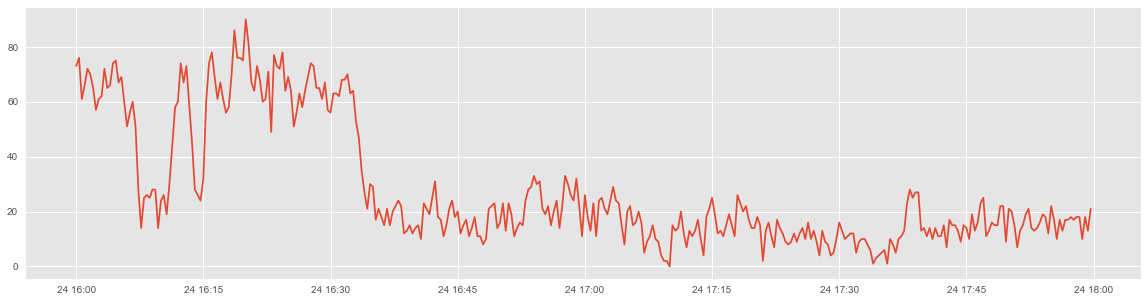

In [33]:
plt.figure(figsize=[20,5])
plt.plot(smoothen_df.index,smoothen_df.SPEED_AVG)

移动平均


C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/1678164060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothen_df['smoothen'] = np_move_avg(np.array(smoothen_df.SPEED_AVG),kernel_size)
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/1678164060.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothen_df['smoothen'] = np_move_avg(np.array(smoothen_df.SPEED_AVG),kernel_size)
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/1678164060.py:6: SettingWithCopyWarning: 
A value is trying t

Text(0.5, 1.0, 'Move Avg Smoothing')

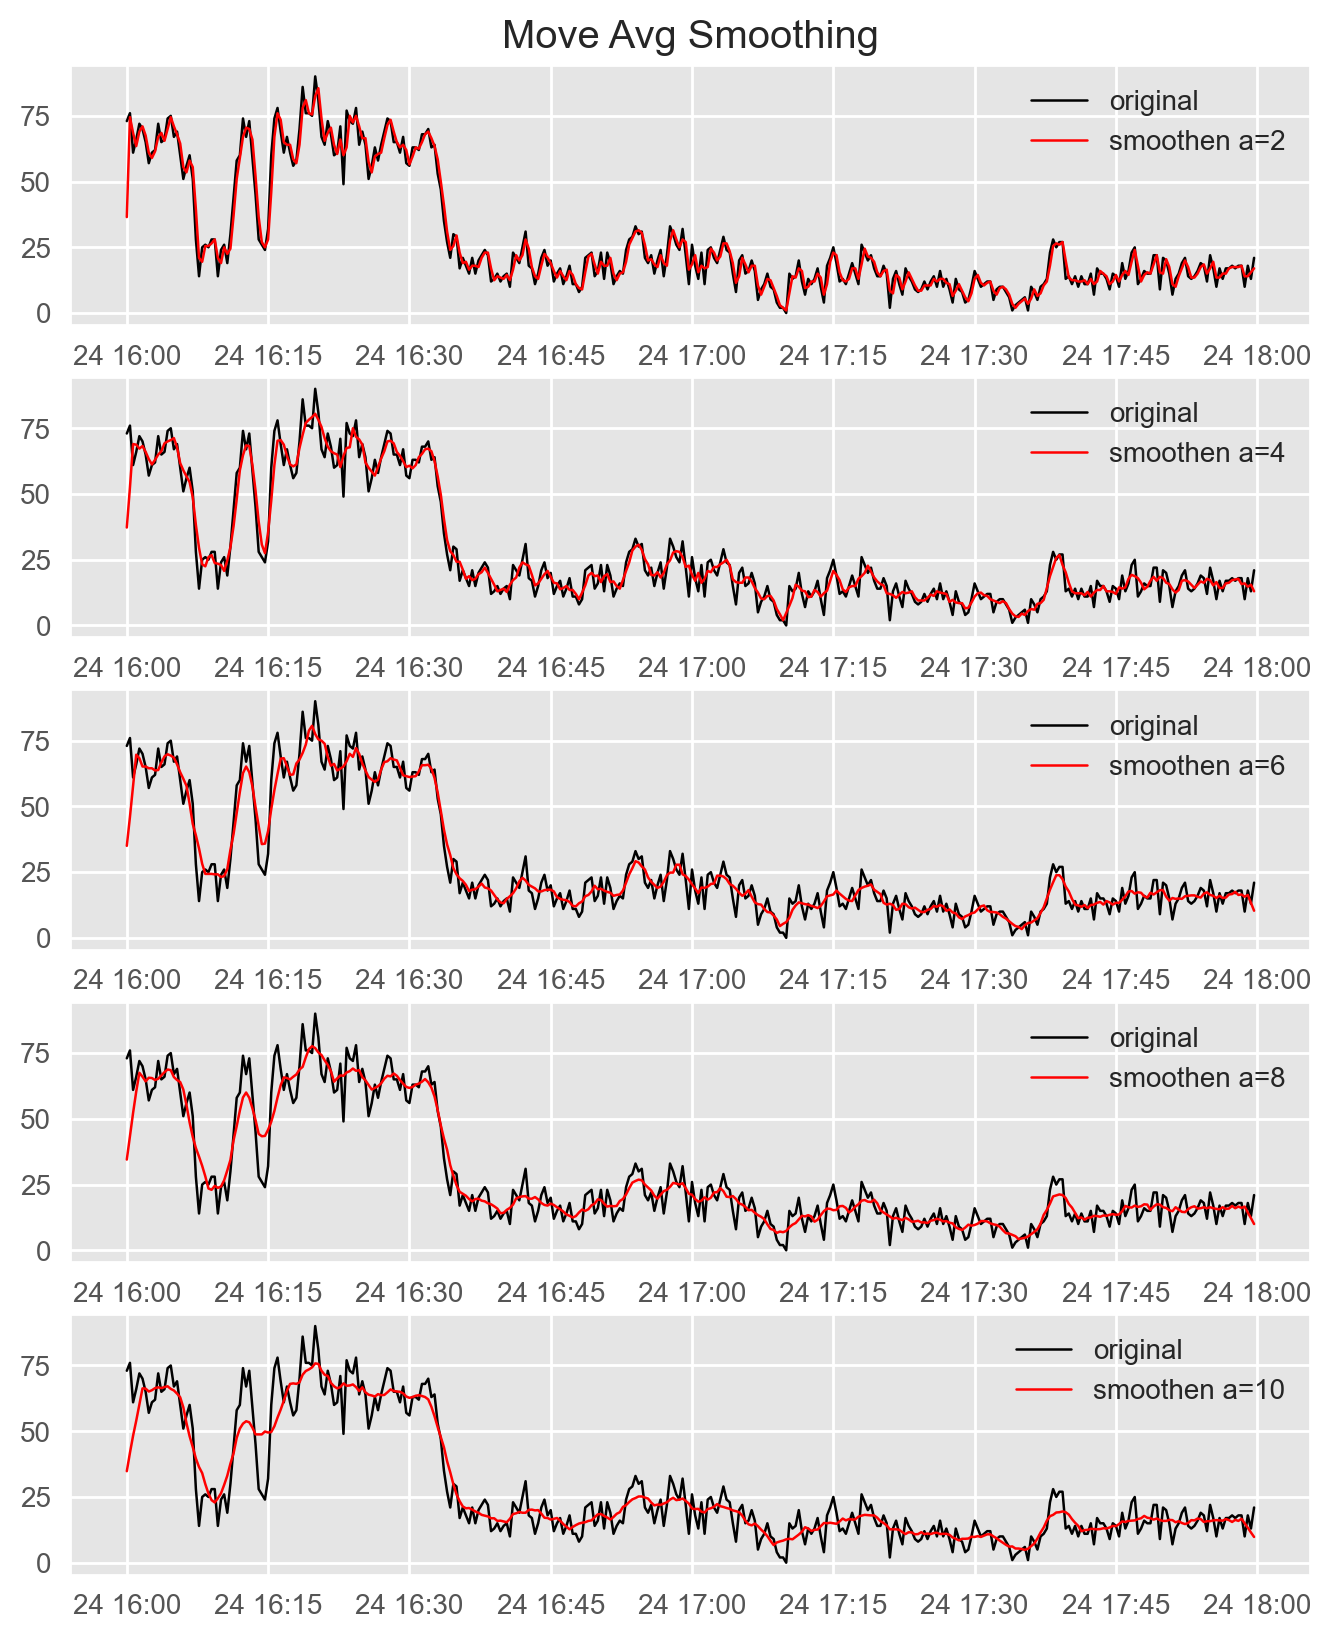

In [34]:
def np_move_avg(a,n,mode="same"):
    return(np.convolve(a, np.ones((n,))/n, mode=mode))
fig,ax=plt.subplots(5,1,figsize=[8,10],dpi=200)
i=0
for kernel_size in range(2,11,2):
    smoothen_df['smoothen'] = np_move_avg(np.array(smoothen_df.SPEED_AVG),kernel_size)

    ax[i].plot(smoothen_df.index,smoothen_df.SPEED_AVG,label='original',linewidth=0.9,color='black')
    ax[i].plot(smoothen_df.index,smoothen_df.smoothen,label='smoothen'+' a={:.0f}'.format(kernel_size),linewidth=0.9,color='red')
    ax[i].legend(loc='upper right')
    i+=1
ax[0].set_title('Move Avg Smoothing')

    

指数平滑

In [35]:
np.arange(0,1,0.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

D:\programs\envs\python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/4039780299.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothen_df['smoothen'] = list(fit1.fittedvalues)
D:\programs\envs\python38\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/4039780299.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

Text(0.5, 1.0, 'Exponential Smoothing')

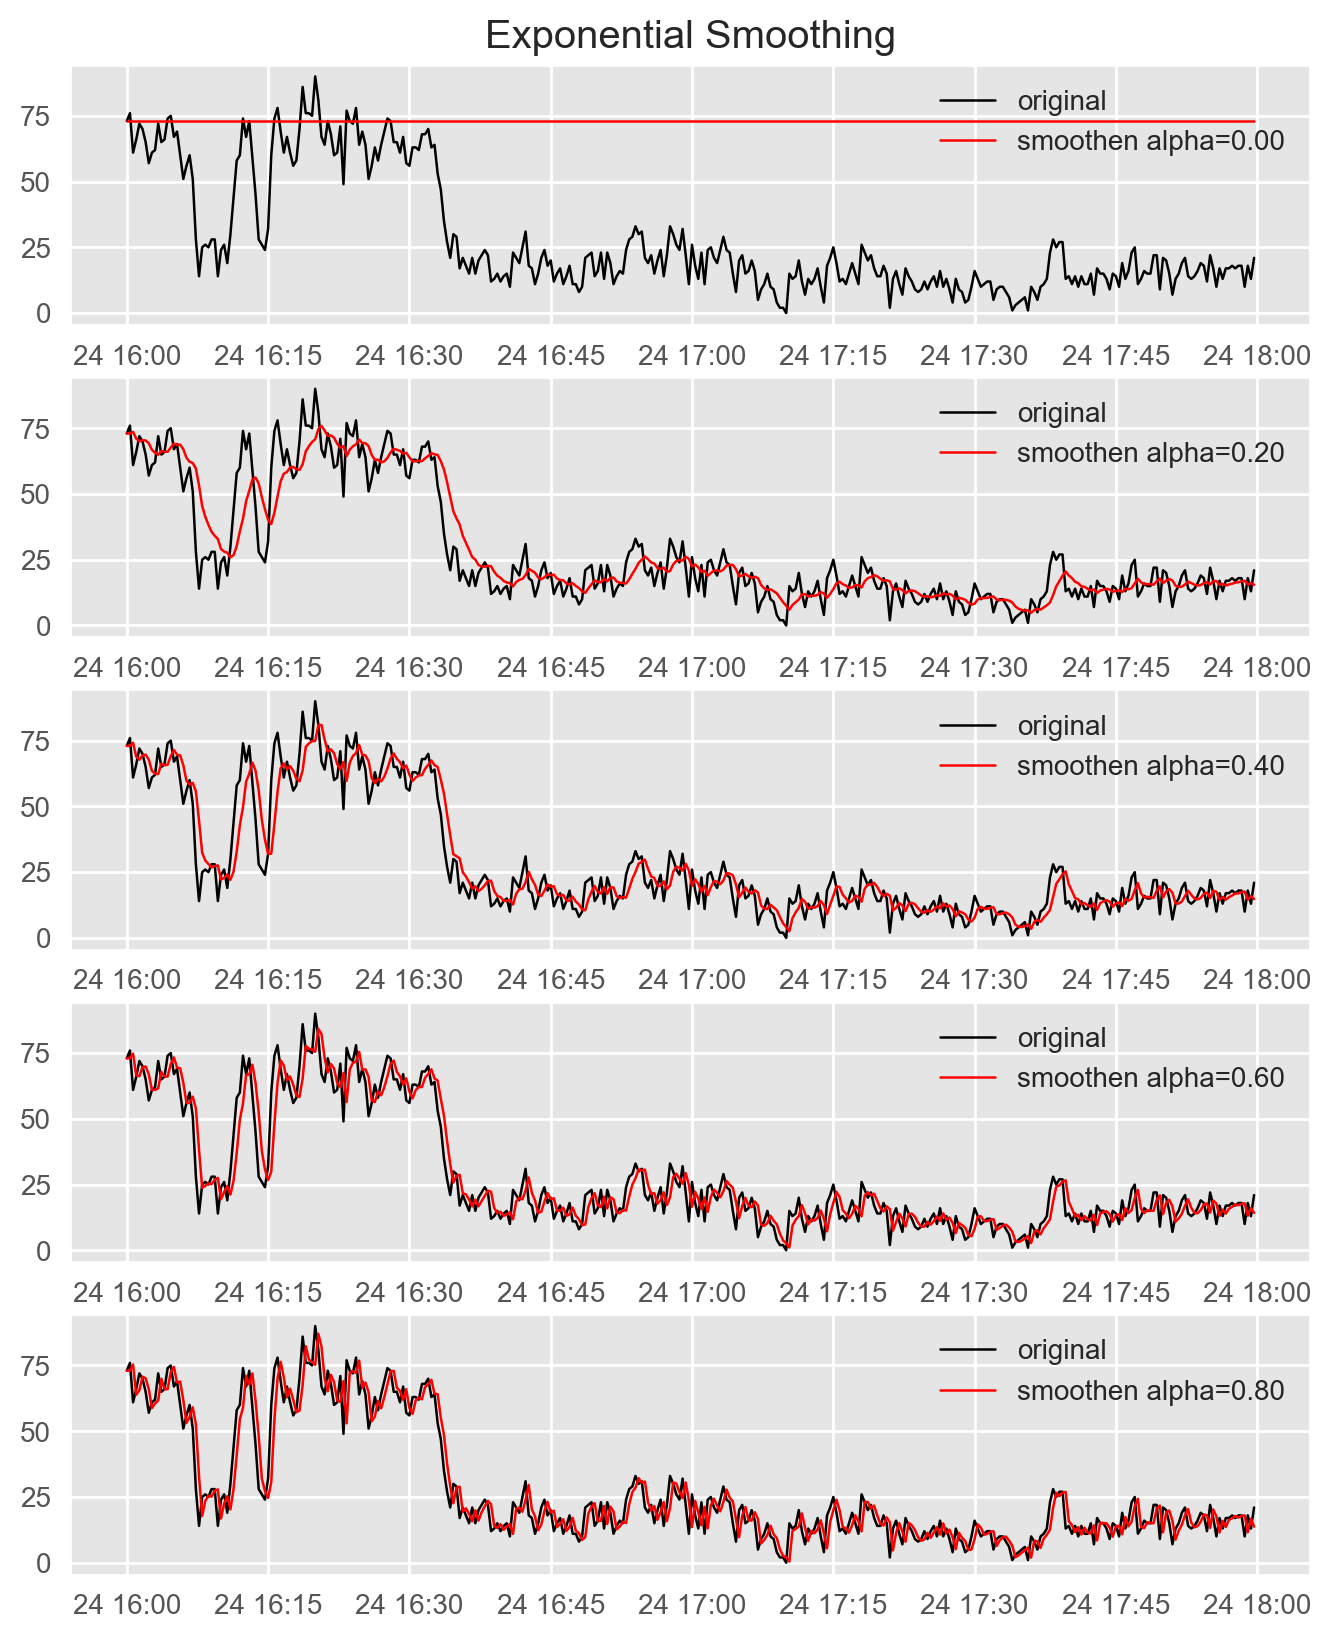

In [36]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
fig,ax=plt.subplots(5,1,figsize=[8,10],dpi=200)
i=0
for alpha in np.arange(0,1,0.2):
    
    fit1 =  SimpleExpSmoothing(np.array(smoothen_df.SPEED_AVG))\
        .fit(smoothing_level=alpha,optimized=False)
    smoothen_df['smoothen'] = list(fit1.fittedvalues)
    # fig,ax = plt.subplots(figsize=[20,5],dpi=200)
    ax[i].plot(smoothen_df.index,smoothen_df.SPEED_AVG,label='original',linewidth=0.9,color='black')
    ax[i].plot(smoothen_df.index,smoothen_df.smoothen,label='smoothen'+' alpha={:.2f}'.format(alpha),linewidth=0.9,color='red')
    ax[i].legend(loc='upper right')
    i+=1
ax[0].set_title('Exponential Smoothing')

卡尔曼滤波

C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/3650562966.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothen_df['smoothen'] = Kalman1D(smoothen_df.SPEED_AVG,damping=Q)
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/3650562966.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  smoothen_df['smoothen'] = Kalman1D(smoothen_df.SPEED_AVG,damping=Q)
C:\Users\SEELEA~1\AppData\Local\Temp/ipykernel_27968/3650562966.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Text(0.5, 1.0, 'Kalman Smoothing')

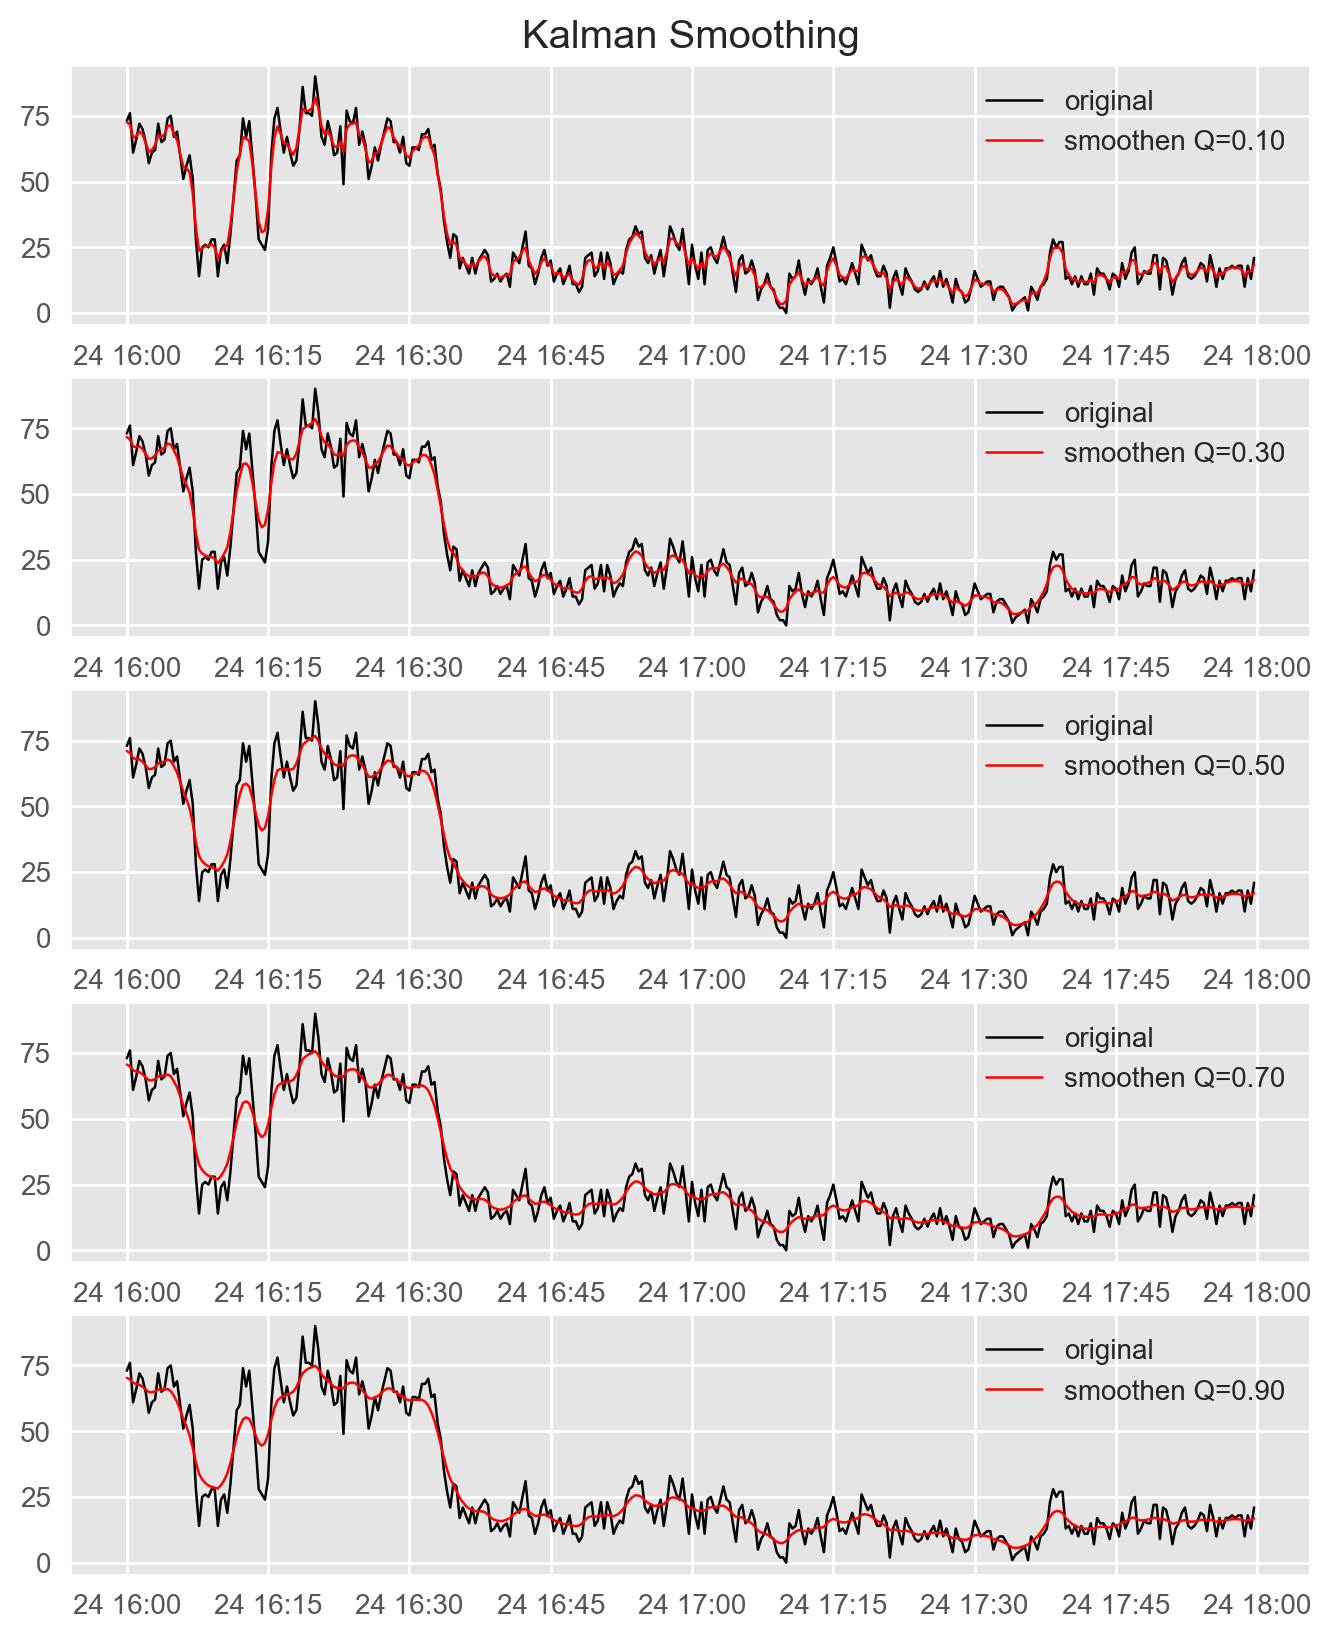

In [37]:
from pykalman import KalmanFilter
def Kalman1D(observations,damping=1):
    # To return the smoothed time series data
    observation_covariance = damping
    initial_value_guess = observations[0]
    transition_matrix = 1
    transition_covariance = 0.1
    initial_value_guess
    kf = KalmanFilter(
            initial_state_mean=initial_value_guess,
            initial_state_covariance=observation_covariance,
            observation_covariance=observation_covariance,
            transition_covariance=transition_covariance,
            transition_matrices=transition_matrix
        )
    pred_state, state_cov = kf.smooth(observations)
    return pred_state


i=0
# plt.subplots()
fig,ax=plt.subplots(5,1,figsize=[8,10],dpi=200)
for Q in np.arange(0.1,1,0.2):
    smoothen_df['smoothen'] = Kalman1D(smoothen_df.SPEED_AVG,damping=Q)
    # fig,ax = plt.subplots(figsize=[20,5],dpi=200)
    ax[i].plot(smoothen_df.index,smoothen_df.SPEED_AVG,label='original',linewidth=0.9,color='black')
    ax[i].plot(smoothen_df.index,smoothen_df.smoothen,label='smoothen'+' Q={:.2f}'.format(Q),linewidth=0.9,color='red')
    ax[i].legend()
    i+=1
ax[0].set_title('Kalman Smoothing')